# Determining Queer-Affirming vs non-Affirming Churches: A Web Scraping and Text Analysis Project

**Project Description**:  
The goal of this project is to develop a comprehensive database of churches in Australia, where each church is flagged as being queer-affirming or not. This will provide more clarity to queer individuals looking for places of worshop where they will accepted and treated equally. 

**Goals**:  
1. Extract relevant textual information from church websites.  
2. Clean and preprocess the text data for analysis.  
3. Identify patterns, keywords, and indicators of queer-affirming vs non-affirming language.  
4. Flag each church as 'affirming", "non-affirming", or "unknown". 

**Author**:  
Travis Rutledge, travisrutledge@gmail.com

**Last Updated**:  
12/02/2025

**Notebook Outline**:  
1. Collecting a List of Australian Churches
2. URL Text Scraping
2. Data Cleaning  
3. Text Preprocessing  
4. Sentiment Analysis  
5. Results

# Libraries

In [10]:
import os # Allows to intract with operating system, such as environment variables and system commands
import requests # Allows for http requests
from bs4 import BeautifulSoup # HTML web scraping tool
from urllib.parse import urljoin, urlparse # Manipulates URLs for better web scraping 
import pandas as pd # Data cleaning and transformation
import nltk
#nltk.download('all')
from nltk.tokenize import word_tokenize # Separates text into individual words 
from nltk.corpus import stopwords # Filters out common words like 'the' and 'is' 
from nltk.util import ngrams # Creates bigrams, which are used for sentimental analysis
from collections import Counter # Counts the number of unique words in each data set
from textblob import TextBlob # Sentiment analysis 
import matplotlib.pyplot as plt # data exploration and visualisation
from sklearn.feature_extraction.text import TfidfVectorizer # Converts raw text into numerical representations 
from sklearn.model_selection import train_test_split # Splits data into training (80%) and testing (20%) datasets.
from sklearn.linear_model import LogisticRegression #A  supervised machine learning algorithm used for classification of affirming and nonaffirming
from sklearn.metrics import classification_report, accuracy_score # Evaluates model performance with precision, recall, and F1-score

# 1. Collecting a list of Australian Churches
The first step is to gather a list of Australian churches, which includes their names, URL, address, and coordinates. This is done by using the Google Places API, which allows for a 1,000 search requests per month. Each request can return up to 20 places. Each query has a maximum squre range of 50km, so 50km coordinate squares will need to be determined in order to facilitate a comprehensive search of churches across Australia. 

## Search Parameters

In [11]:
# API 
API_KEY = os.getenv("GOOGLE_PLACE_API_KEY")

# Search parameters, adjust as needed
locations = [
# Victoria
"-37.840935,144.946457",  # Melbourne
"-36.616619,143.260361",  # St Arnaud
"-37.292870,144.951263",  # Kilmore
"-37.987461,145.214859",  # Dandenong
"-36.124428,146.876389",  # Wodonga
"-37.966667,144.133331",  # Lethbridge
"-37.823002,144.998001",  # Richmond
"-37.636604,144.806427",  # Bulla
"-36.948254,145.104477",  # Northwood
"-37.020100,145.131454",  # Seymour
# New South Wales
"-33.865143,151.209900",  # Sydney
"-30.640720,151.500702",  # Uralla
"-34.033749,151.071198",  # Kirrawee
"-30.452242,152.897964",  # Bellingen
"-32.569473,151.178818",  # Singleton
"-33.968109,151.104080",  # Hurstville
"-30.614943,152.852127",  # Bowraville
"-34.673820,150.844376",  # Kiama
"-32.023331,151.958755",  # Gloucester
"-32.897633,151.736984",  # Mayfield
"-28.175995,153.541672",  # Tweed Heads
"-33.084999,151.634995",  # Swansea
"-34.583332,150.866669",  # Shellharbour
"-32.916668,151.750000",  # Newcastle
"-33.794498,150.976501",  # Constitution Hill
"-33.932999,151.259003",  # South Coogee
"-33.485867,149.667435",  # Brewongle
"-34.443371,150.061356",  # Bermagui
"-34.033749,151.071198",  # Kirrawee
# Queensland
"-27.4678,153.0281",      # Brisbane
"-19.007626,146.189194",  # Paluma
"-25.898890,139.351669",  # Birdsville
"-23.439493,144.251389",  # Longreach
"-19.568516,147.406387",  # Ayr
"-27.066668,152.966660",  # Caboolture
"-20.267500,148.716949",  # Airlie Beach
"-27.616667,152.850006",  # Collingwood Park
"-27.454914,153.007126",  # Red Hill
"-26.798412,153.132965",  # Caloundra
"-27.395847,152.937881",  # Ferny Hills
"-27.585613,152.983658",  # Durack
"-27.302221,152.988815",  # Strathpine
"-28.000767,153.429642",  # Surfers Paradise
]
radius = 10000  # Search radius in meters
type = ["church", "place_of_worship"] # Type of place to search for

## Search Execution

In [12]:
# API URLs
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
details_base_url = "https://maps.googleapis.com/maps/api/place/details/json"

def get_places_data(api_key, location, radius, type):
    all_results = []  # To store all results across pages
    params = {
        "key": api_key,
        "location": location,
        "radius": radius,
        "type": type
    }
    
    while True:
        # Make the API request
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break
        
        # Parse the response
        data = response.json()
        print(f"API Response: {data}")  # Print full response to debug
        all_results.extend(data.get("results", []))  # Add results from the current page
        
        # Check if there is a next page
        next_page_token = data.get("next_page_token")
        if not next_page_token:
            break  # No more pages, exit loop
        
        # Wait a few seconds before using the next_page_token to avoid request denial
        import time
        time.sleep(5)  # Google requires a short delay before using the next page token
        
        print(f"Fetched {len(data.get('results', []))} results")
        print(f"Next Page Token: {next_page_token}")

        # Update params with the next_page_token
        params.update({"pagetoken": next_page_token})
    
        if "status" in data and data["status"] == "OVER_QUERY_LIMIT":
            print("Google is rate-limiting you. Try again later.")
            break  # Stop fetching if limit is reached

    return all_results


# Function to get website URLs from Place Details API
def get_place_details(api_key, place_id):
    params = {
        "place_id": place_id,
        "fields": "website",  # Request only the website field
        "key": api_key
    }
    response = requests.get(details_base_url, params=params)
    if response.status_code == 200:
        details_data = response.json()
        return details_data.get("result", {}).get("website", "N/A")
    else:
        print(f"Error fetching details for place_id {place_id}: {response.status_code}")
        return "N/A"

# Function to extract URLs
def extract_website_urls(data, api_key):
    websites = []
    for result in data:
        place_id = result.get("place_id")
        website = get_place_details(api_key, place_id)
        if website and website != "N/A":
            websites.append(website)
    return websites

# Main script to collect the list of church websites
if __name__ == "__main__":
    all_websites = []  # To store all websites from multiple locations

    # Loop through locations
    for location in locations:
        print(f"Fetching data for location: {location}")
        # Fetch data from Google Places API with pagination
        places_data = get_places_data(API_KEY, location, radius, type)
        
        if places_data:
            # Extract website URLs
            website_urls = extract_website_urls(places_data, API_KEY)
            all_websites.extend(website_urls)

    # Remove duplicates by converting to a set and back to a list
    all_websites = list(set(all_websites))
    
    # Save to a text file or use it for further steps
    with open("church_websites.txt", "w") as f:
        for url in all_websites:
            f.write(url + "\n")
    
    print(f"Website URLs saved to 'church_websites.txt'")

Fetching data for location: -37.840935,144.946457
API Response: {'html_attributions': [], 'next_page_token': 'AVzFdbm8yj5pLehG3wO3qlvmOI28_LHWEc0QrHFUU0P-rFuwchu0EYsScljYCkjtrD7HhohOyofUXAnlintJTyZM4ylzWf2VVcKQWXZcSOGLV-2cb4eiaF2BQ4aV8hdtfSvgHKt5tvuTGxtIeXUobKTaKrDsjW4gDwbdaFIvBU6LkMiQbVd5ZXe2DGI1a1waSnt3MZN7d3FpgZ9LomJjMTURPmHr-CJxwLDVDfVFMQI11Z-PxSvJbXs6PPdL_Kg1b4Mp1rTqzpDEvE-Jd1yX6g3dV8E3PHfyoggolj6EOkFftnhtSqvG9yui3K_rf6DUJbVo44EYaQxLCck8w_eqEj8qRzuSkN3qn8YI68A0IBE-R9aH2i29MZwjcrUqF9fM_DnusLGABvLoSlRsjghRUxXYPdNVSD9eCvFHGK2FcRGhhFZFeVnfUNpN-SA3rUr_Mg', 'results': [{'business_status': 'OPERATIONAL', 'formatted_address': '41/59 Sims St, West Melbourne VIC 3003', 'geometry': {'location': {'lat': -37.80174239999999, 'lng': 144.9114513}, 'viewport': {'northeast': {'lat': -37.80033357010728, 'lng': 144.9124863298927}, 'southwest': {'lat': -37.80303322989273, 'lng': 144.9097866701072}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/worship_general-71.png', 'icon_ba

# 2. URL Text Scraping
Using the chuch URLs gathered in the previous step, data is scraped from each church's website. Data is broken down by website, webpage, and text content. Because each website can have numerous pages, the scraping tool only scrapes websites that are found in the top navigation of each HTML website.

To Do:
    Another web scraping tool such as Selinium or something else will need to be used to scrape from javascript websites. The current setup only scrapes HTML websites. 

## Playwright Scraping

## Beautiful Soup HMTL Scraping

In [13]:
# 2. URL Text Scraping
# Load the list of church websites generated in Section 1
websites = []

# Read the URLs from the file created in Section 1
with open("church_websites.txt", "r") as f:
    websites = [line.strip() for line in f.readlines()]

# Define scraping parameters
MAX_DEPTH = 1  # Maximum depth of scraping
SKIP_PATTERNS = ["tribe_events", "eventDisplay", "ical", "page", "eventDate"]  # Patterns to skip

# Normalize URL function
from urllib.parse import urlparse, urlunparse, urljoin

def normalize_url(url):
    parsed = urlparse(url)
    normalized = urlunparse((parsed.scheme, parsed.netloc, parsed.path, "", "", ""))
    return normalized

# Function to validate URLs
def is_valid_url(url):
    try:
        parsed = urlparse(url)
        return bool(parsed.netloc) and bool(parsed.scheme)
    except:
        return False

def scrape_stories(soup):
    # Check for story-like structure
    story_container = soup.find('div', class_='masonry-grid')  # Adjust if needed
    if not story_container:
        return None  # No stories found

    # Extract stories
    stories = story_container.find_all('div', class_='masonry-grid-item')
    story_list = []
    for story in stories:
        title = story.find('b').get_text(strip=True) if story.find('b') else 'No Title'
        description = story.find('i').get_text(strip=True) if story.find('i') else 'No Description'
        link = story.find('a')['href'] if story.find('a') else 'No Link'
        story_list.append({
            'title': title,
            'description': description,
            'link': link
        })
    return story_list

def scrape_default(soup, current_url):
    # Extract main content
    content_div = soup.find("div", {"class": "main-content"})
    if not content_div:
        content_div = soup.find("body")  # Fallback to entire body
    page_text = content_div.get_text(separator=" ", strip=True) if content_div else ""

    # Clean up text
    page_text = page_text.replace("Read More", "").strip()
    return {"URL": current_url, "Text": page_text}

def scrape_website(start_url, max_depth=MAX_DEPTH):
    visited = set()  # Keep track of visited URLs
    to_visit = [(start_url, 0)]  # Start with the homepage and depth level 0
    data = []  # To store scraped data

    while to_visit:
        current_url, depth = to_visit.pop(0)

        # Skip if the maximum depth is exceeded
        if depth > max_depth:
            continue

        # Skip if already visited
        normalized_url = normalize_url(current_url)
        if normalized_url in visited:
            continue

        print(f"Visiting: {current_url}")
        try:
            # Fetch the URL
            response = requests.get(current_url, timeout=10)
            response.raise_for_status()

            # Check the content type
            content_type = response.headers.get("Content-Type", "")
            if "text/html" not in content_type:
                print(f"Skipping non-HTML content: {current_url}")
                continue

        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch {current_url}: {e}")
            continue

        # Mark as visited
        visited.add(normalized_url)

        # Parse HTML
        soup = BeautifulSoup(response.text, "html.parser")

        # Try scraping stories
        stories = scrape_stories(soup)
        if stories:
            print(f"Stories found on {current_url}!")
            for story in stories:
                data.append({"Website": start_url, "URL": current_url, **story})
            continue  # Skip link traversal for story pages

        # Fallback to default scraping logic
        page_data = scrape_default(soup, current_url)
        data.append({"Website": start_url, **page_data})

        # Extract and filter links only from navigation elements
        nav_links = soup.find_all(['nav', 'ul'])
        links = [urljoin(current_url, a['href']) for nav in nav_links for a in nav.find_all('a', href=True)]

        for link in links:
            normalized_link = normalize_url(link)
            if start_url in normalized_link and normalized_link not in visited:
                to_visit.append((link, depth + 1))  # Add the next depth level

    return data

# Scrape each website
if __name__ == "__main__":
    all_data = []  # To store all scraped data

    total_websites = len(websites)  # Get the total number of websites
    for idx, start_url in enumerate(websites, start=1):  # Use enumerate to track the index
        print(f"Scraping {idx} of {total_websites} websites: {start_url}")
        scraped_data = scrape_website(start_url)
        all_data.extend(scraped_data)

    # Convert the scraped data to a pandas DataFrame
    df = pd.DataFrame(all_data)

    # Validate URLs
    df["URL"] = df["URL"].apply(lambda x: x if is_valid_url(x) else None)

    # Drop rows where URL is invalid
    df = df.dropna(subset=["URL"])
    print("Invalid URLs have been removed from the dataset.")

    # Filter out rows with empty text
    df_cleaned = df[df["Text"].notnull() & (df["Text"].str.strip() != "")]
    print("Cleaned DataFrame:")
    print(df_cleaned.head())

    # Save cleaned data to CSV
    df_cleaned.to_csv("scraped_data.csv", index=False, encoding="utf-8")
    print("Scraped data saved to 'scraped_data.csv'")

Scraping 1 of 1202 websites: http://burwood-croydon.unitingchurch.org.au/
Visiting: http://burwood-croydon.unitingchurch.org.au/
Visiting: http://burwood-croydon.unitingchurch.org.au/about
Visiting: http://burwood-croydon.unitingchurch.org.au/indexm
Visiting: http://burwood-croydon.unitingchurch.org.au/leaders-staff
Visiting: http://burwood-croydon.unitingchurch.org.au/gallery
Visiting: http://burwood-croydon.unitingchurch.org.au/pastors-blog
Visiting: http://burwood-croydon.unitingchurch.org.au/contact
Visiting: http://burwood-croydon.unitingchurch.org.au/mission-statement
Visiting: http://burwood-croydon.unitingchurch.org.au/worship-times
Visiting: http://burwood-croydon.unitingchurch.org.au/newsletter
Failed to fetch http://burwood-croydon.unitingchurch.org.au/newsletter: 429 Client Error: Too Many Requests for url: http://burwood-croydon.unitingchurch.org.au/newsletter
Scraping 2 of 1202 websites: https://local.churchofjesuschrist.org/en/au/qld/inala/20-blackthorn-st?utm_source=gmb

# 3. Data Cleaning
This step focuses on deleting irrelevent data and correcting any inconsistencies or special characters. This code chunk lists the number of duplicate rows before and after removal, and it provides a .csv file of the cleaned data at the end

In [14]:
# Remove rows with missing or empty text
df_cleaned = df[df["Text"].notnull() & (df["Text"].str.strip() != "")]

# Remove duplicates
# Check for duplicate rows based on all columns
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")

# Drop duplicates
df_cleaned = df.drop_duplicates()

# Confirm duplicates were removed
print(f"Number of duplicate rows after removal: {df_cleaned.duplicated().sum()}")

# Handle encoding issues
# Define a function to clean special characters and encoding issues
def clean_encoding_issues(text):
    if isinstance(text, str):
        # Replace or remove problematic characters
        text = text.encode('utf-8', errors='ignore').decode('utf-8', errors='ignore')
        # Optionally: replace specific problematic sequences
        text = text.replace("â€™", "'")  # Replace right single quotation mark
        text = text.replace("â€œ", '"')  # Replace left double quotation mark
        text = text.replace("â€", '"')  # Replace right double quotation mark
        text = text.replace("â€“", "-")  # Replace en dash
        text = text.replace("â€¦", "...")  # Replace ellipsis
        text = text.replace("â€‹", "")  # Remove zero-width space
    return text

# Apply the cleaning function to the "Text" column
df_cleaned["Text"] = df_cleaned["Text"].apply(clean_encoding_issues)

# Save cleaned data to CSV
df_cleaned.to_csv("cleaned_data.csv", index=False, encoding="utf-8")

print("Data cleaning complete. Cleaned data saved to 'cleaned_data.csv'.")

Number of duplicate rows before removal: 0
Number of duplicate rows after removal: 0
Data cleaning complete. Cleaned data saved to 'cleaned_data.csv'.


## 3a. Cleaning, Tokenising, and Bigramming
This section sets all the text to lower case, tokenizes the text (breaking it into individual words), removes extranous words like "this" and "is", removes anything that is not a letter or a number, and generates bigrams for each entry

In [15]:
# Ensure all entries in the "Text" column are strings
df_cleaned["Text"] = df_cleaned["Text"].fillna("").astype(str)

# Lowercase the text
df_cleaned["Text"] = df_cleaned["Text"].str.lower()

# Tokenize the text (breaks the text into individual words)
df_cleaned["Tokens"] = df_cleaned["Text"].apply(word_tokenize)

# Remove stopwords (like 'the' and 'is')
stop_words = set(stopwords.words("english"))
df_cleaned["Tokens"] = df_cleaned["Tokens"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

# Remove anything that is not a letter or number, like punctuation and special characters
df_cleaned["Tokens"] = df_cleaned["Tokens"].apply(
    lambda tokens: [word for word in tokens if word.isalnum()]
)

# Remove illegal characters using pandas' built-in string functions
df_cleaned = df_cleaned.map(lambda x: ''.join(filter(lambda y: y.isprintable(), str(x))) if isinstance(x, str) else x)

# Generate bigrams for each text entry
df_cleaned["Bigrams"] = df_cleaned["Tokens"].apply(
    lambda tokens: list(ngrams(tokens, 2))
)

# Generate trigrams for each text entry
df_cleaned["Trigrams"] = df_cleaned["Tokens"].apply(
    lambda tokens: list(ngrams(tokens, 3))
)

# 4. Text Preprocessing

## 4a. Keyword-Based Classification
These are the keywords and bigrams that will be used to flag if a church is affirming or non-affirming. These are broken out by keywords, bigrams, and trigrams. A separate variable is made to flag certain denominations that are affirming or nonaffirming. FOr example, the uniting church of australia is affirming while the Australian Christian Church is nonaffirming

In [16]:
# Affirming
affirming_keywords = ["lgbt", "lgbtqia", "lbgtq+", "lgbtqia+", "queer", "bisexual", "lbgti"]

affirming_bigrams = [("sexual", "orientation"), ("gender", "identity"), ("queer", "affirming"), ("sexual", "identities"),("sexual", "identity"),
("gender", "identities")]

affirming_movements = [("uniting"), "uca"]

affirming_movements_bigrams = [("uniting", "church"), ("mcc", "sydney")]

# Nonaffirming
non_affirming_keywords = ["homosexuality", "ssa"]

non_affirming_bigrams = [("traditional", "marriage"), ("biblical","values"),("god's","design"),
("husband","wife"), ("same", "sex"), ("sex", "attraction"), ("biological", "sex"), ("biblical", "view"),
("institution", "marriage"), ("husbands", "wives"), ("one", "woman"), ("man","woman")]

non_affirming_trigrams = [("biblical", "view", "marriage"), ("same", "sex", "attracition")]

non_affirming_movements = ["acc", "www.acc.org.au", "hillsong", "presbyterian.org.au", "presbyterian"]

non_affirming_movements_trigrams = [("australian", "christian", "churches"), ("australian", "christian", "church")]

## 4b. Flagging Movements/Networks

In [17]:
# Network flagging function to include evidence
def flag_affirming_or_non_affirming_network_with_evidence(row):
    affirming_movement_evidence = []
    non_affirming_movement_evidence = []
    detected_movement = ""  # To store movement name

    # Check for affirming movements/networks
    for word in row["Tokens"]:
        if word in affirming_movements:
            affirming_movement_evidence.append(word)
            detected_movement = word  # Capture movement name

    for bigram in row["Bigrams"]:
        if bigram in affirming_movements_bigrams:
            affirming_movement_evidence.append(" ".join(bigram))
            detected_movement = " ".join(bigram)  # Capture movement name

    # Check for non-affirming movements/networks
    for word in row["Tokens"]:
        if word in non_affirming_movements:
            non_affirming_movement_evidence.append(word)
            detected_movement = word  # Capture movement name

    for trigram in row["Trigrams"]:
        if trigram in non_affirming_movements_trigrams:
            non_affirming_movement_evidence.append(" ".join(trigram))
            detected_movement = " ".join(trigram)  # Capture movement name

    # Determine the flag and evidence
    if affirming_movement_evidence:
        return "Affirming", ", ".join(affirming_movement_evidence), detected_movement  # Affirming with evidence
    elif non_affirming_movement_evidence:
        return "Non-Affirming", ", ".join(non_affirming_movement_evidence), detected_movement  # Non-Affirming with evidence
    else:
        return "Unknown", "", ""  # Neither found

# Apply the updated function
df_cleaned[["AffirmingFlag", "Evidence", "Movement"]] = df_cleaned.apply(
    lambda row: pd.Series(flag_affirming_or_non_affirming_network_with_evidence(row)), axis=1
)

# Display results
df_cleaned.head()


,Website,URL,Text,Tokens,Bigrams,Trigrams,AffirmingFlag,Evidence,Movement
0,http://burwood-croydon.unitingchurch.org.au/,http://burwood-croydon.unitingchurch.org.au/,burwood croydon uniting church about us missio...,"[burwood, croydon, uniting, church, us, missio...","[(burwood, croydon), (croydon, uniting), (unit...","[(burwood, croydon, uniting), (croydon, unitin...",Affirming,"uniting, uniting, uniting, uniting, uniting ch...",uniting church
1,http://burwood-croydon.unitingchurch.org.au/,http://burwood-croydon.unitingchurch.org.au/about,burwood croydon uniting church about us missio...,"[burwood, croydon, uniting, church, us, missio...","[(burwood, croydon), (croydon, uniting), (unit...","[(burwood, croydon, uniting), (croydon, unitin...",Affirming,"uniting, uniting, uniting, uniting, uniting ch...",uniting church
2,http://burwood-croydon.unitingchurch.org.au/,http://burwood-croydon.unitingchurch.org.au/in...,burwood croydon uniting church about us missio...,"[burwood, croydon, uniting, church, us, missio...","[(burwood, croydon), (croydon, uniting), (unit...","[(burwood, croydon, uniting), (croydon, unitin...",Affirming,"uniting, uniting, uniting, uniting, uniting, u...",uniting church
3,http://burwood-croydon.unitingchurch.org.au/,http://burwood-croydon.unitingchurch.org.au/le...,burwood croydon uniting church about us missio...,"[burwood, croydon, uniting, church, us, missio...","[(burwood, croydon), (croydon, uniting), (unit...","[(burwood, croydon, uniting), (croydon, unitin...",Affirming,"uniting, uniting, uniting, uniting, uniting, u...",uniting church
4,http://burwood-croydon.unitingchurch.org.au/,http://burwood-croydon.unitingchurch.org.au/ga...,burwood croydon uniting church about us missio...,"[burwood, croydon, uniting, church, us, missio...","[(burwood, croydon), (croydon, uniting), (unit...","[(burwood, croydon, uniting), (croydon, unitin...",Affirming,"uniting, uniting, uniting, uniting, uniting ch...",uniting church


## 4c. Flagging Affirming and Non-Affirming Language

In [18]:
# Flagging function to include evidence
def flag_affirming_or_non_affirming_with_evidence(row):
    affirming_evidence = []
    non_affirming_evidence = []

    # Check for affirming keywords or bigrams
    for word in row["Tokens"]:
        if word in affirming_keywords:
            affirming_evidence.append(word)
    for bigram in row["Bigrams"]:
        if bigram in affirming_bigrams:
            affirming_evidence.append(" ".join(bigram))
    
    # Check for non-affirming keywords, bigrams, or trigrams
    for word in row["Tokens"]:
        if word in non_affirming_keywords:
            non_affirming_evidence.append(word)
    for bigram in row["Bigrams"]:
        if bigram in non_affirming_bigrams:
            non_affirming_evidence.append(" ".join(bigram))
    for trigram in row["Trigrams"]:
        if trigram in non_affirming_trigrams:
            non_affirming_evidence.append(" ".join(trigram))
    
    # Determine the flag and evidence
    if affirming_evidence:
        return "Affirming", ", ".join(affirming_evidence)  # Affirming with evidence
    elif non_affirming_evidence:
        return "Non-Affirming", ", ".join(non_affirming_evidence)  # Non-Affirming with evidence
    else:
        return "Unknown", ""  # Neither found

# Apply the updated function
df_cleaned[["AffirmingFlag", "Evidence"]] = df_cleaned.apply(
    lambda row: pd.Series(flag_affirming_or_non_affirming_with_evidence(row)), axis=1
)

# Save to CSV
df_cleaned.to_csv("scraped_cleaned_data_with_evidence.csv", index=False, encoding = "utf-8")

print("Updated dataset with evidence, saved to 'scraped_cleaned_data_with_evidence.csv'.")

# Filter out rows with "Unknown" in the AffirmingFlag column
filtered_df = df_cleaned[df_cleaned["AffirmingFlag"] != "Unknown"]

# Save to CSV
filtered_df.to_csv("scraped_cleaned_data_with_evidence_no_unknowns.csv", index=False, encoding="utf-8")

print("Updated dataset with evidence and removed unknowns, saved to 'scraped_cleaned_data_with_evidence.csv_no_unknowns'.")

# Save to xlsx 
df_cleaned.to_excel("scraped_cleaned_data_with_evidence.xlsx", index=False, engine="openpyxl")

filtered_df.to_excel("scraped_cleaned_data_with_evidence_no_unknowns.xlsx", index=False, engine="openpyxl")


Updated dataset with evidence, saved to 'scraped_cleaned_data_with_evidence.csv'.
Updated dataset with evidence and removed unknowns, saved to 'scraped_cleaned_data_with_evidence.csv_no_unknowns'.


## 4c. Exploratory Text Analysis

### 4c1. Top 20 Keywords

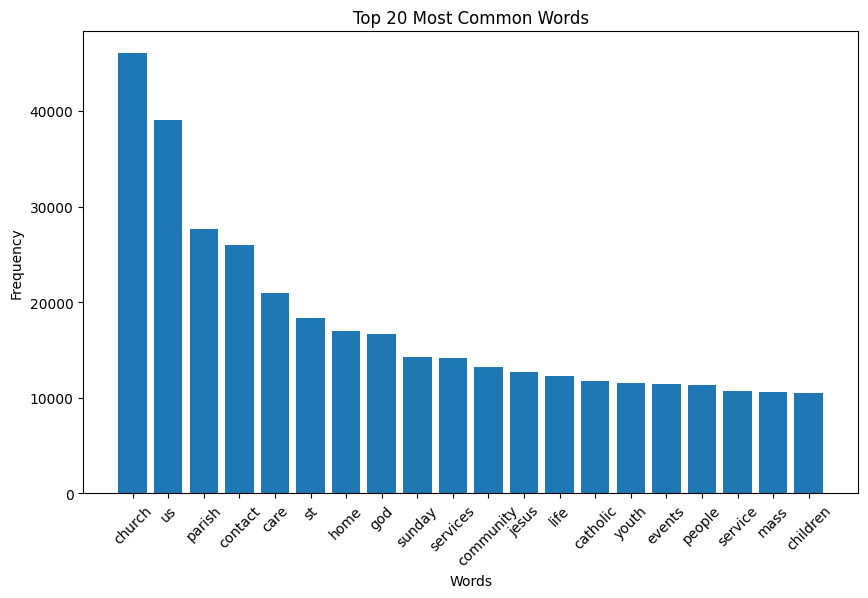

In [19]:
# Flatten the list of tokens into a single list
all_tokens = [token for tokens in df_cleaned["Tokens"] for token in tokens]

# Count word frequencies
word_counts = Counter(all_tokens)

# Get the top 20 most common words
top_words = word_counts.most_common(20)

# Display as a bar chart
words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### 4c2. Top 20 Bigrams

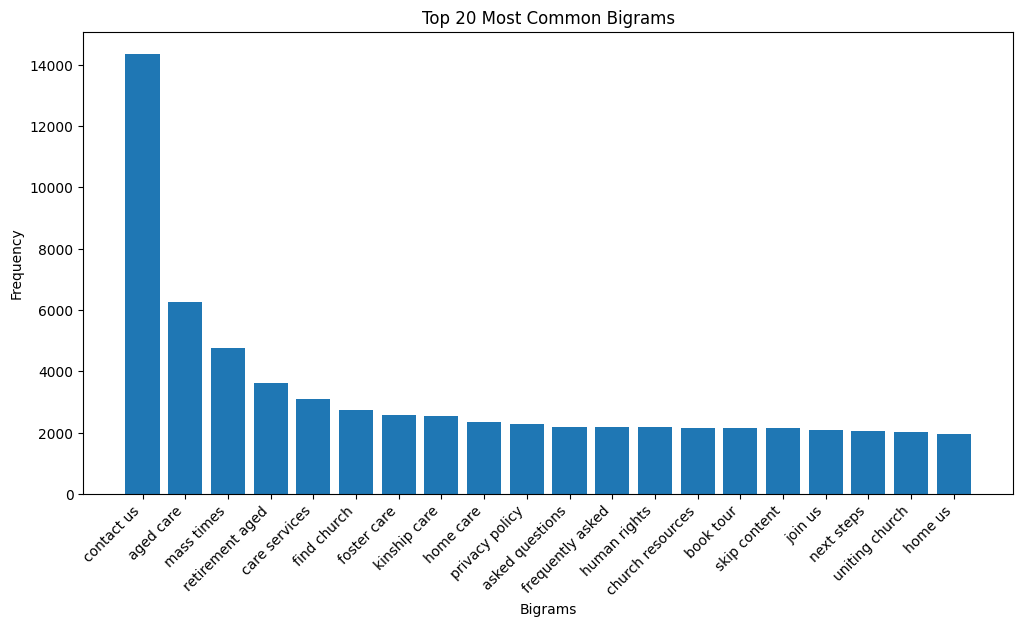

In [20]:
from collections import Counter

# Flatten the list of bigrams into a single list
all_bigrams = [bigram for bigrams in df_cleaned["Bigrams"] for bigram in bigrams]

# Count bigram frequencies
bigram_counts = Counter(all_bigrams)

# Get the top 20 most common bigrams
top_bigrams = bigram_counts.most_common(20)

# Display as a bar chart
bigrams, counts = zip(*top_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigram_labels, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Most Common Bigrams")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.show()


## 5. Test

### Load and prepare data

In [21]:
# Load the cleaned dataset
df = pd.read_csv("scraped_cleaned_data_with_evidence.csv")

# Drop unknown labels (since they don’t help in supervised learning)
df = df[df["AffirmingFlag"] != "Unknown"]

# Check class distribution
print(df["AffirmingFlag"].value_counts())

# Define features (text) and target (label)
X = df["Text"]   # Church website text
y = df["AffirmingFlag"]  # Affirming or Non-Affirming

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


AffirmingFlag
Non-Affirming    74
Affirming        38
Name: count, dtype: int64


### Convert text to TF-IDF

In [22]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    stop_words="english",  # Remove common words
    ngram_range=(1,2)  # Include unigrams and bigrams
)

# Fit on training data and transform both train & test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Print shape of transformed data
print("Train data shape:", X_train_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape)

Train data shape: (89, 5000)
Test data shape: (23, 5000)


### Train Logistic Regression Model

In [23]:
# Initialize and train logistic regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

### Evaluate the Model

In [24]:
# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.91
               precision    recall  f1-score   support

    Affirming       1.00      0.60      0.75         5
Non-Affirming       0.90      1.00      0.95        18

     accuracy                           0.91        23
    macro avg       0.95      0.80      0.85        23
 weighted avg       0.92      0.91      0.90        23



## 5. Sentiment Analysis

## Unsupervised Learning

### Basic Flagging

In [ ]:
# Sentiment analysis function
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a score: >0 positive, <0 negative, 0 neutral

# Apply sentiment analysis to cleaned text
df_cleaned["SentimentScore"] = df_cleaned["Text"].apply(get_sentiment)

# Categorize rows based on sentiment score
def categorize_sentiment(score):
    if score > 0.2:  # Adjust thresholds as needed
        return "Likely Affirming"
    elif score < -0.2:
        return "Likely Non-Affirming"
    else:
        return "Neutral/Unknown"

df_cleaned["SentimentCategory"] = df_cleaned["SentimentScore"].apply(categorize_sentiment)

# Combine sentiment with affirming keyword flag for a final assessment
def final_flag(row):
    if row["AffirmingFlag"]:
        return "Affirming"
    elif row["SentimentCategory"] == "Likely Non-Affirming":
        return "Non-Affirming"
    else:
        return "Unknown"

df_cleaned["FinalFlag"] = df_cleaned.apply(final_flag, axis=1)

# Save updated DataFrame to CSV
output_file = "scraped_cleaned_with_sentiment.csv"
df_cleaned.to_csv(output_file, index=False, encoding="utf-8")

print(f"Results saved to {output_file}")


### TF-IDF and K-Means Clustering

In [ ]:
# Load the data
df = pd.read_csv("scraped_cleaned_data.csv")

# Combine Tokens and Bigrams into a single column for TF-IDF
df["Combined"] = df["Tokens"].apply(lambda x: " ".join(eval(x))) + " " + \
                 df["Bigrams"].apply(lambda x: " ".join(["_".join(bigram) for bigram in eval(x)]))

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    stop_words=None,    # No need for stop words, as Tokens are already cleaned
    ngram_range=(1, 1)  # Focus on unigrams (and bigrams if added earlier)
)

# Apply TF-IDF to the combined Tokens and Bigrams column
X_tfidf = tfidf.fit_transform(df["Combined"])

# View feature names for reference
print(f"Number of TF-IDF Features: {len(tfidf.get_feature_names_out())}")

from sklearn.cluster import KMeans

# Initialize and fit K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust `n_clusters` as needed
df["Cluster"] = kmeans.fit_predict(X_tfidf)

# Analyze cluster distribution
print(df["Cluster"].value_counts())

# Save clusters or predictions back to the dataset
df.to_csv("updated_church_data.csv", index=False)

# Save TF-IDF matrix for future use
from scipy.sparse import save_npz
save_npz("tfidf_matrix.npz", X_tfidf)



## Supervised Learning

# Results
This section collapses the results of the sentiment analysis for each website. The end result is a table where each row is an individual church with their name, website, address, coordinates, whether they are affirming or non-affirming, and the evidence (a url) where they state their affirmation or non-affirmation.

# Misc Code

In [ ]:
"""
# Testing if there are church's without their type set as church
# API URLs
base_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
details_base_url = "https://maps.googleapis.com/maps/api/place/details/json"

# Function to get data from Google Places API with pagination
def get_places_data(api_key, query, location, radius, type):
    all_results = []  # To store all results across pages
    params = {
        "key": api_key,
        "query": query, 
        "location": location,
        "radius": radius,
    }
    
    while True:
        # Make the API request
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break
        
        # Parse the response
        data = response.json()
        all_results.extend(data.get("results", []))  # Add results from the current page
        
        # Check if there is a next page
        next_page_token = data.get("next_page_token")
        if not next_page_token:
            break  # No more pages, exit loop
        
        # Wait a few seconds before using the next_page_token to avoid request denial
        import time
        time.sleep(3)  # Google requires a short delay before using the next page token
        
        print(f"Fetched {len(data.get('results', []))} results")
        print(f"Next Page Token: {next_page_token}")

        # Update params with the next_page_token
        params.update({"pagetoken": next_page_token})
    
    return all_results

# Function to get website URLs from Place Details API
def get_place_details(api_key, place_id):
    params = {
        "place_id": place_id,
        "fields": "website,types",
        "key": api_key
    }
    response = requests.get(details_base_url, params=params)
    
    if response.status_code == 200:
        details_data = response.json().get("result", {})
        return details_data.get("website", "N/A"), details_data.get("types", ["N/A"])
    else:
        print(f"Error fetching details for place_id {place_id}: {response.status_code}")
        return "N/A", ["N/A"]

# Main script
if __name__ == "__main__":
    results = []

    for location in locations:
        print(f"Fetching data for location: {location}")
        places_data = get_places_data(API_KEY, query, location, radius, type)

        for place in places_data:
            name = place.get("name", "Unknown")
            place_id = place.get("place_id")
            
            if place_id:
                website, place_types = get_place_details(API_KEY, place_id)
                place_types_str = ", ".join(place_types)  # Convert list to string for better readability
                
               # Store all results (NO filtering)
                results.append([name, website, place_types_str])

      # Convert results to DataFrame
    df = pd.DataFrame(results, columns=["Church Name", "Website", "Types"])
    
    # Print results as a table in console
    print(df.to_string(index=False))

    # Save to CSV file
    df.to_csv("churches_without_church_type.csv", index=False)
    
    print("Results saved to 'churches_without_church_type.csv'")
    """